# Explaining Customer Churn Predictions with Python's Lime Package

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn
import sklearn
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import scipy
import os
import lime
import lime.lime_tabular
#import catboost
#import xgboost
#import lightgbm
import plotly.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
#import bokeh

%matplotlib inline


In [270]:
'''import pickle

## For pickling model
## picklepath argument is string in the format 'something.pkl'

def pickle_model(model, picklepath):
    
    #create pickle path
    pickle_path = picklepath
    #open pickle
    pickle_model = open(pickle_path, 'wb')
    pickle.dump(model, pickle_model)
    pickle_model.close

    
## For unpickling model

def unpickle_model(picklepath):
    
    #open pickle
    unpickle_model = open(pickle_path, 'r')
    model = pickle.load(unpickle_model)
    unpickle_model.close
    
    return model

'''


"import pickle\n\n## For pickling model\n## picklepath argument is string in the format 'something.pkl'\n\ndef pickle_model(model, picklepath):\n    \n    #create pickle path\n    pickle_path = picklepath\n    #open pickle\n    pickle_model = open(pickle_path, 'wb')\n    pickle.dump(model, pickle_model)\n    pickle_model.close\n\n    \n##\xa0For unpickling model\n\ndef unpickle_model(picklepath):\n    \n    #open pickle\n    unpickle_model = open(pickle_path, 'r')\n    model = pickle.load(unpickle_model)\n    unpickle_model.close\n    \n    return model\n\n"

### Importing the loans dataset and generating descriptive stats

In [271]:
data = pd.read_csv('data/IBM_telco_dataset.csv', sep = ',')
data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We need to convert Total Charges to type float and drop customer Id column

In [272]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [273]:
data['TotalCharges'] = data['TotalCharges'].replace(" ", np.nan)
data['PaymentMethod'] = data['PaymentMethod'].replace("Bank transfer (automatic)", "Bank transfer")
data['PaymentMethod'] = data['PaymentMethod'].replace("Credit card (automatic)", "Credit card")
data['TotalCharges'] = data['TotalCharges'].astype(float)

data['TotalCharges'] = data.apply(lambda x: float(x['TotalCharges']), axis =1)
data['SeniorCitizen'] = data.apply(lambda x: str(x['SeniorCitizen']), axis =1)
data = data.drop(columns='customerID')


### Count missing values

There are 11 missing values for Total Charges

In [274]:
data.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

We can see that total charges is roughly equal to Monthly charges multiplied by tenure. We can rid of one of the variables due to collineraity - the correlation matrix further down shows that Total charges are more strongly related to tenure. We will get rid of this later

In [275]:
data['TotalCharges']/(data['MonthlyCharges']*data['tenure'])

0       1.000000
1       0.975830
2       1.004178
3       0.967034
4       1.072489
5       1.029227
6       0.994490
7       1.014790
8       1.038049
9       1.001910
10      0.904674
11      1.077836
12      0.976084
13      0.991144
14      1.018408
15      1.010353
16      0.952645
17      0.974464
18      0.957156
19      0.985114
20      1.000000
21      0.851221
22      1.000000
23      1.008894
24      1.017087
25      0.922604
26      1.017068
27      1.000000
28      0.980217
29      0.993818
          ...   
7013    1.005460
7014    0.996869
7015    0.992285
7016    1.000000
7017    0.969235
7018    1.000000
7019    1.051091
7020    1.037326
7021    1.014214
7022    0.998399
7023    0.993697
7024    0.971899
7025    0.981589
7026    1.013952
7027    0.976928
7028    0.992532
7029    0.987425
7030    0.978803
7031    1.004879
7032    1.000000
7033    0.994036
7034    0.998347
7035    0.999866
7036    1.021297
7037    0.932099
7038    0.978037
7039    0.990916
7040    1.0640

## Correlation Matrix

In [75]:
z= data.corr().values
x = list(data.corr().columns)
y = list(data.corr().columns)

corr_data = [
    go.Heatmap(
        z=z,
        x=x,
        y=y,
        colorscale='Viridis',
    )
]

layout = go.Layout(
    title='Correlation between features',
    xaxis = dict(ticks=''),
    yaxis = dict(ticks='')
)

figure = go.Figure(data =corr_data, layout = layout )
py.iplot(figure)

#plotly.tools.set_credentials_file(username='ryankarlos', api_key='iWskjOL5qPS67FlgOsy6')


/Users/ryannazareth/anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



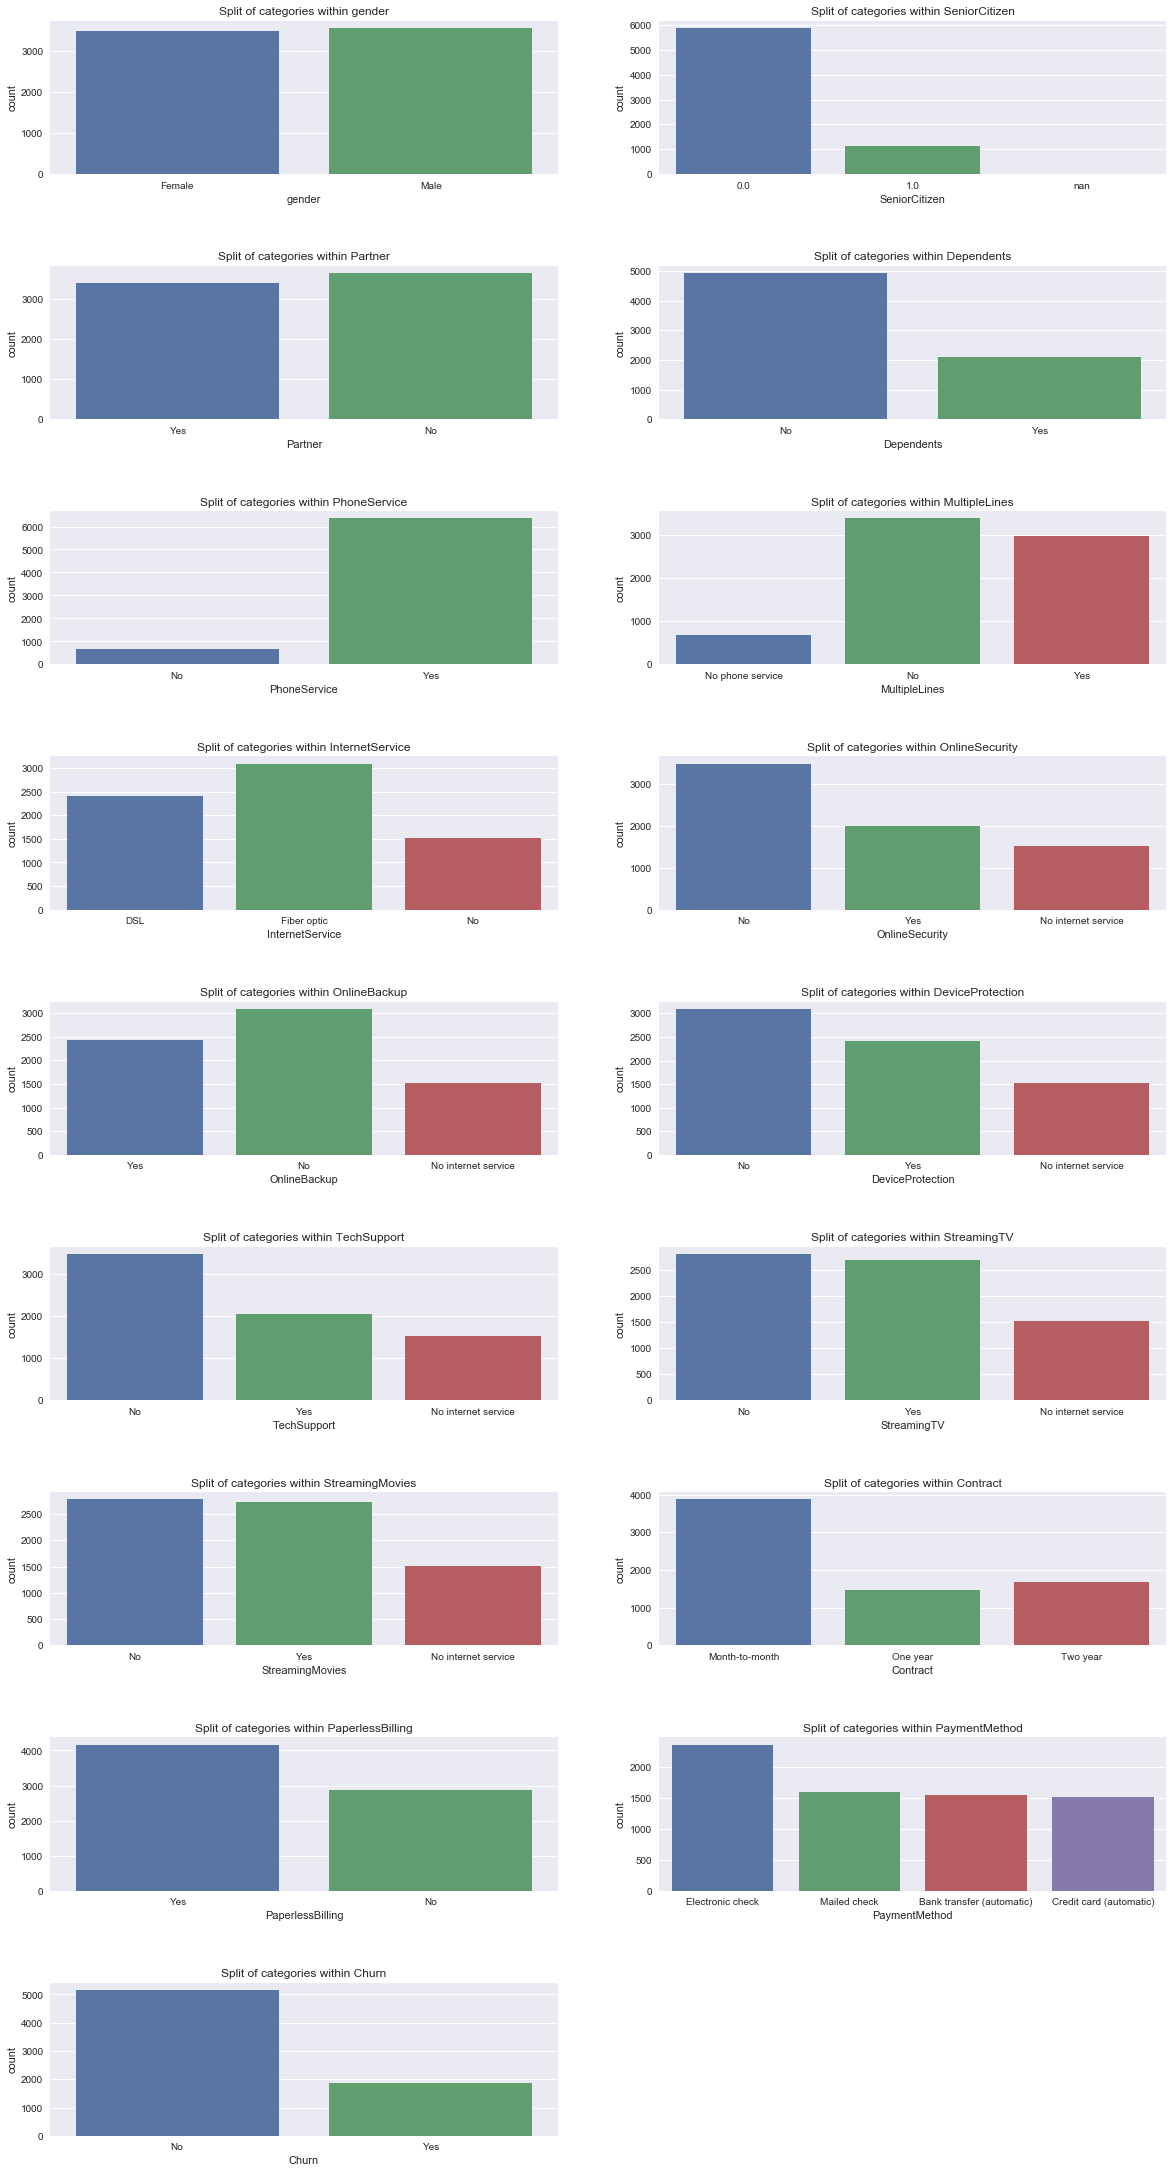

In [115]:

categories = list(data.select_dtypes(['object']).columns)

fig = plt.subplots(figsize = (20,75))
length = len(categories)
for i,j in enumerate(categories):
    plt.subplot(length,2,i+1)  # arguments to subplot are number of rows, number of columns and index for each plot
    plt.subplots_adjust(hspace=0.6) # distance between each plot row
    sns.countplot(x =j, data = data)
    plt.title("Split of categories within " + j )
  

In [62]:
Churn = data[data['Churn'] == 'Yes'].groupby('Contract')['Churn'].count().reset_index(name='counts')
non_churn = data[data['Churn'] == 'No'].groupby('Contract')['Churn'].count().reset_index(name='counts')


trace1 = go.Bar(
    x= Churn['Contract'],
    y= Churn['counts'],
    name='Customers who churn'
)
trace2 = go.Bar(
    x= non_churn['Contract'],
    y= non_churn['counts'],
    name='Customers who do not churn'
)

barchart1 = [trace1, trace2]
layout = go.Layout(
    barmode='group',
        xaxis=dict(
        domain=[0, 0.5]
    ),
    title='Churn status by Contract Type'
)

#fig = go.Figure(data=barchart, layout=layout)
#py.iplot(fig, filename='grouped-bar')

barchart = [trace1, trace2]


layout = go.Layout(
    barmode='group',
    title='Churn status by Contract'
)

fig = go.Figure(data = barchart, layout = layout)

py.iplot(fig, filename='grouped-bar')




In [31]:
trace1 = go.Histogram(
    x=data[data['Churn'] == 'Yes']['MonthlyCharges'],
    name='Churn customers',
    opacity=0.85
)
trace2 = go.Histogram(
    x=data[data['Churn'] == 'No']['MonthlyCharges'],
    name='non-churn customers',
    opacity=0.75
)

histogram = [trace1, trace2]
layout = go.Layout(barmode='stack', title='Churn status by Monthly Charges', xaxis = dict(title = 'Charge (£)'))
fig = go.Figure(data=histogram, layout=layout)

py.iplot(fig)

In [32]:
trace1 = go.Histogram(
    x=data[data['Churn'] == 'Yes']['TotalCharges'],
    name='Churn customers',
    opacity=0.85
)
trace2 = go.Histogram(
    x=data[data['Churn'] == 'No']['TotalCharges'],
    name='non-churn customers',
    opacity=0.75
)

histogram = [trace1, trace2]
layout = go.Layout(barmode='stack', title='Churn status by Total Charges', xaxis = dict(title = 'Charge (£)'))
fig = go.Figure(data=histogram, layout=layout)

py.iplot(fig)

In [66]:


trace0 = go.Scatter(
    x = data[data['Churn'] == 'Yes']['tenure'],
    y = data[data['Churn'] == 'Yes']['TotalCharges'],
    mode = 'markers',
    name = 'Churn',
    marker = dict(
        size = 10,
        color = 'rgba(152, 0, 0, .8)',
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    )
)


trace1 = go.Scatter(
    x = data[data['Churn'] == 'No']['tenure'],
    y = data[data['Churn'] == 'No']['TotalCharges'],
    xaxis='x2',
    yaxis='y2',
    mode = 'markers',
    name = 'non Churn',
    marker = dict(
        size = 10,
        color = 'rgba(0, 200, 0.5, .5)',
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    )
)


balance = [trace0, trace1]

layout = dict(title = 'Churn by Tenure and charges',
                  xaxis=dict(
                        domain=[0, 0.45]
                       ),
                   xaxis2=dict(
                       domain=[0.5, 1.1]
                    ),
                  yaxis2=dict(
                       anchor='x2'
                    )
               )

fig1 = dict(data=balance, layout=layout)
py.iplot(fig1, filename='styled-scatter')



Lets get rid of the 'Total Charges' variable as we have seen enough evidence that tenure and monthly charges variables should suffice instead.

In [276]:
data = data.drop(columns='TotalCharges')

Finally, we use a One-hot encoder, so that the classifier does not take our categorical features as continuous features. We will use this encoder only for the classifier, not for the explainer - and the reason is that the explainer must make sure that a categorical feature only has one value.

In [277]:

# List comprehension for getting the indices for the categorical columns. We have sliced the original dataframe to exclude the target variable
categorical_features = [data.columns.get_loc(x) for x in data.iloc[:, :-1].select_dtypes('object').columns]  

label = data['Churn']

le = LabelEncoder()
label = le.fit_transform(label)
class_names = le.classes_


categorical_names = {}

encoded_features = pd.get_dummies(data.drop('Churn', axis = 1))
feature_names = encoded_features.columns


for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data.iloc[:,feature])
    data.iloc[:,feature] = le.transform(data.iloc[:, feature])
    categorical_names[feature] = le.classes_



features = data.drop('Churn', axis = 1)
    
X_train, X_test, y_train, y_test = train_test_split(features , label, test_size = 0.3)

encoder = sklearn.preprocessing.OneHotEncoder(categorical_features=categorical_features)
encoder.fit(features)
encoded_train = encoder.transform(X_train)
encoded_test = encoder.transform(X_test)


In [278]:
sm = SMOTE(random_state=12, ratio = 1.0)
encoded_train_re, y_train_re = sm.fit_sample(encoded_train, y_train)


/Users/ryannazareth/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [279]:
clf_rf = RandomForestClassifier(criterion= 'gini', n_estimators= 100)



In [280]:
clf_rf.fit(encoded_train_re, y_train_re)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [281]:
clf_rf.score(encoded_test, y_test)
###sklearn.metrics.accuracy_score(y_test, clf_rf.predict(X_test))

0.76147657359204923

             precision    recall  f1-score   support

          0       0.81      0.88      0.84      1529
          1       0.59      0.46      0.51       584

avg / total       0.75      0.76      0.75      2113

Confusion matrix, without normalization
[[1343  186]
 [ 318  266]]


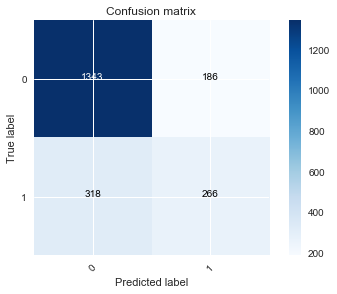

In [282]:
y_pred = clf_rf.predict(encoded_test)
print(classification_report(y_test, y_pred)) 

cnf_matrix = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cnf_matrix, classes = [0,1])
plt.show()


In [283]:
rf_feature_imp = clf_rf.feature_importances_
feature_names = encoded_features.columns

feature_imp = pd.DataFrame({'features' : feature_names, 'importance': rf_feature_imp})
feature_imp = feature_imp.sort_values(by = 'importance', ascending = False)

feature_imp = feature_imp.iloc[:10]

trace1 = go.Bar(
    y= feature_imp['features'],
    x= feature_imp['importance'],
    orientation = 'h'
)

barchart = [trace1]

layout = go.Layout(
    xaxis=dict(domain=[0.1, 0.85]),
    title='Feature Importance plot'
)

fig = go.Figure(data=barchart, layout=layout)
py.iplot(fig, filename='single-bar')

Our explainer (and most classifiers) takes in numerical data, even if the features are categorical. We thus transform all of the string attributes into integers, using sklearn's LabelEncoder. We use a dict to save the correspondence between the integer values and the original strings, so that we can present this later in the explanations.


Our explainer (and most classifiers) takes in numerical data, even if the features are categorical. 
We thus transform all of the string attributes into integers, using sklearn's LabelEncoder. 
We use a dict to save the correspondence between the integer values and the original strings, 
so that we can present this later in the explanations.

In [295]:


explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train) ,feature_names = list(X_train.columns),class_names=class_names,
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names, kernel_width=3)


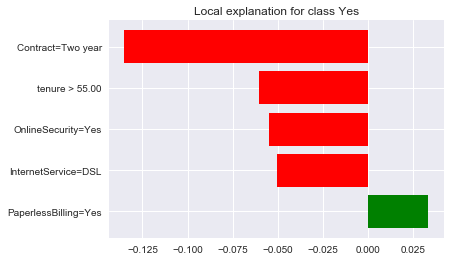

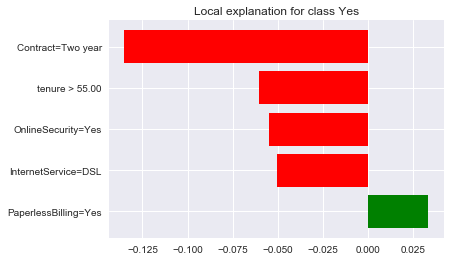

In [299]:
predict_fn = lambda x: clf_rf.predict_proba(encoder.transform(x))

test = np.array(X_test)
np.random.seed(1)
i = 100
exp = explainer.explain_instance(test[i], predict_fn, num_features=5)
print('')
exp.show_in_notebook(show_all=False)

exp.as_pyplot_figure()